# CWatM data vs. CAMELSGB

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd
import geopandas as gpd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
data_dir = Path("/datadrive/data")
ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")
cw = xr.open_dataset(data_dir / "cwatm.nc").drop(["spatial_ref", "x", "y"])

# ensure aligned
ds = ds.sel(time=cw.time)
cw["station_id"] = cw["station_id"].astype(int)
ds["station_id"] = ds["station_id"].astype(int)

In [4]:
from scripts.cwatm_data.ldd_draft import vectorize_rowcol_to_latlon_points, load_basin_file_ldd
cwat_dir = data_dir / "CWATM"
shapefile_out_dir = cwat_dir / "shapefile"

locations = xr.open_dataset(cwat_dir / "basin_locations.nc")
points_outfile = gpd.read_file(cwat_dir / "gauge_points/gauge_points.shp")
ldd_gdf = gpd.read_file(shapefile_out_dir / "catchment_boundaries.shp").set_index("value")

# Regional Analysis

In [3]:
import geopandas as gpd 

assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"
assert (data_dir / "RUNOFF/gis_data_Tommy/UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp").exists(), ""

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")

hydro_regions = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp").to_crs(epsg=4326)
hydro_regions = hydro_regions.loc[~np.isin(hydro_regions["NAME"], ["Northern Ireland", "Republic of Ireland"])]

In [4]:
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points, get_region_station_within, region_abbrs, assign_region_coordinate
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")
names = static["gauge_name"].to_dataframe()

In [5]:
regions_list = get_region_station_within(points, hydro_regions, points=points)
all_points = gpd.GeoDataFrame(points).join(names).join(regions_list)
regions_data = regions_list.to_frame().join(regions_list.map(region_abbrs).rename("region_abbr"))

<AxesSubplot:>

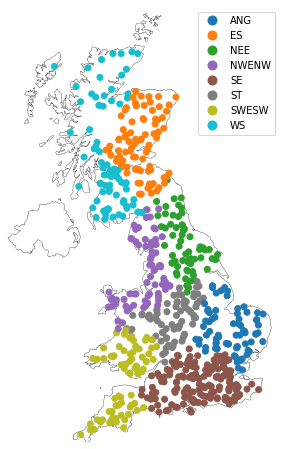

In [213]:
_gdf = gpd.GeoDataFrame(regions_data.join(points))
ax = initialise_gb_spatial_plot()
_gdf.plot("region_abbr", legend=True, ax=ax)

In [6]:
ds = assign_region_coordinate(ds, regions_data)
cw = assign_region_coordinate(cw, regions_data)

# Discharge

In [293]:
epsilon = 1e-10
q = ds["discharge_spec"].rename("camels").to_dataset().merge(cw["discharge"].rename("cwatm"))
log_q = np.log(q + epsilon)
norm_log_q = (log_q - log_q.mean()) / log_q.std()
q

<xarray.Dataset>
Dimensions:     (station_id: 671, time: 9131)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2014-12-31
    region      (station_id) object 'WS' 'WS' 'WS' 'WS' ... 'NWENW' 'WS' nan
Data variables:
    camels      (time, station_id) float64 nan 0.75 nan 0.68 ... 1.75 3.03 2.12
    cwatm       (time, station_id) float32 2.361 0.005721 1.624 ... 2.018 1.258

In [66]:
# from tqdm import tqdm

# _cam = log_q["camels"].values.flatten()
# _cwat = log_q["cwatm"].values.flatten()

# lim = min(np.nanmin(_cam), np.nanmin(_cwat)), max(np.nanmax(_cam), np.nanmax(_cwat))
# std = np.mean([np.nanstd(_cam), np.nanstd(_cwat)])
# # color by region?
# regions = np.unique(cw.region.where(~cw.region.isnull(), drop=True).values)

# f, axs = plt.subplots(2, 2, figsize=(3*2, 3*2), sharex=True, sharey=True)
# for ix, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
#     # initialise axes
#     ax = axs[np.unravel_index(ix, (2,2))]
#     ax.set_title(season)
#     ax.set_xlabel("CAMELS-GB")
#     ax.set_ylabel("CWatM")

#     # plot 1:1 line 
#     ax.plot(lim, lim, alpha=0.5, ls="--", color="k")
# #     ax.set_xlim(lim[0] - (std), lim[1] + (std));
# #     ax.set_ylim(lim[0] - (std), lim[1] + (std));

#     # select SEASON data
#     data = log_q.sel(time=log_q["time.season"] == season)
#     pbar = tqdm(regions, desc=season)
    
#     # select REGION data
#     for cix, region in enumerate(pbar):
#         data = data.sel(station_id=data["region"] == region)
#         _cam = data["camels"].values.flatten()
#         _cwat = data["cwatm"].values.flatten()
#         ax.scatter(_cam, _cwat, marker="x", alpha=0.6, color=f"C{cix}", label=region)

# ax.legend()
# plt.tight_layout()

# How different are the distributions?

In [162]:
regions

array(['ANG', 'ES', 'NEE', 'NWENW', 'SE', 'ST', 'SWESW', 'WS'],
      dtype=object)

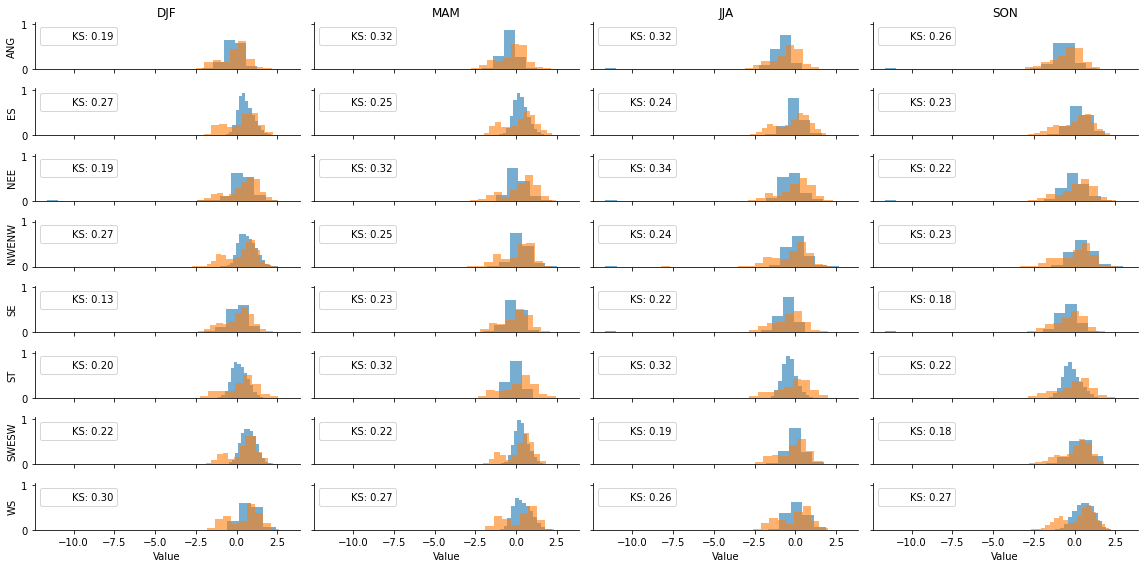

In [282]:
from typing import List
from scipy.stats import kstest


regions = np.unique(cw.region.where(~cw.region.isnull(), drop=True).values)
var1 = "camels"
var2 = "cwatm"
regions = ['ANG', 'ES', 'NEE', 'NWENW', 'SE', 'ST', 'SWESW', 'WS']
seasons = ["DJF", "MAM", "JJA", "SON"]

def plot_grid_of_histograms(ds: xr.Dataset, var1: str, var2: str, regions: List[str], seasons: List[str]) -> np.ndarray:
    # rows = region; columns = season
    f, axs = plt.subplots(
        len(regions), len(seasons), figsize=(4*len(seasons), 1*len(regions)), sharex=True, sharey=True, # subplot_kw={"xlabel": "Log Discharge", "ylabel": "Density"},
        **{"tight_layout": True}
    )

    ks = np.empty(shape=(len(regions), len(seasons)))
    for row_ix, region in enumerate(regions):
        for col_ix, season in enumerate(seasons):
            data = ds.sel(time=ds["time.season"] == season, station_id=ds["region"] == region)

            ax = axs[row_ix, col_ix]
            if row_ix == 0:
                ax.set_title(season)
            if row_ix == len(regions) - 1:
                ax.set_xlabel("Value")
            if col_ix == 0:
                ax.set_ylabel(region)

            statistic = kstest(data[var1].values.flatten(), data[var2].values.flatten()).statistic
            ks[row_ix, col_ix] = statistic
            ax.hist(data[var1].values.flatten(), density=True, bins=20, alpha=0.6);
            ax.hist(data[var2].values.flatten(), density=True, bins=20, alpha=0.6);
            ax.axhline(0, alpha=0, label=f"KS: {statistic:.2f}")
            ax.legend(loc="upper left")
            sns.despine()
    
    return ks
            


def add_mean_rows_columns(ks: np.ndarray) -> np.ndarray:
    # add mean conditions to ks matrix
    ks = np.hstack([ks, ks.mean(axis=1).reshape(-1, 1)])
    ks = np.vstack([ks, ks.mean(axis=0).reshape(1, -1)])
    return ks


ks = plot_grid_of_histograms(norm_log_q, var1, var2, regions, seasons)
ks = add_mean_rows_columns(ks)

Text(0.5, 1.0, 'Max: ANG MAM\nMin: NWENW JJA')

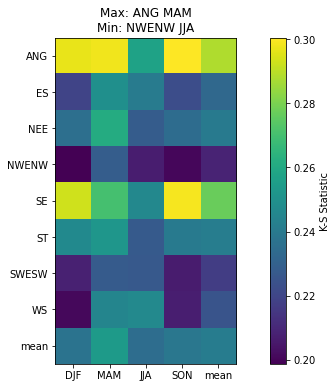

In [394]:
from typing import Any, Dict
from functools import partial


def plot_region_season_matrix(ks: np.ndarray, seasons: List[str], regions: List[str], imshow_kwargs: Dict[str, Any] = {}, cbar_kwargs: Dict[str, Any] = {}):
    f, ax = plt.subplots(figsize=(12, 6))  # figsize=(4*len(seasons), 1*len(regions))
    im = ax.imshow(ks, **imshow_kwargs)

    plt.colorbar(im, **cbar_kwargs)
    # ax.invert_yaxis()
    ax.set_xticks(np.arange(len(seasons)))
    ax.set_xticklabels(seasons);
    ax.set_yticks(np.arange(len(regions)));
    ax.set_yticklabels(regions);
    # f.get_size_inches()

    
plot_ks = partial(plot_region_season_matrix, cbar_kwargs={"label": "K-S Statistic",})

plot_ks(ks, seasons + ["mean"], regions + ["mean"]) # , imshow_kwargs={"vmin": 0.1, "vmax": 0.5})

# max region (by mean)
max_region = regions[np.argmax(ks[:, -1])]
max_season = seasons[np.argmax(ks[-1, :])]
min_region = regions[np.argmin(ks[:, -1])]
min_season = seasons[np.argmin(ks[-1, :])]
plt.gca().set_title(f"Max: {max_region} {max_season}\nMin: {min_region} {min_season}")

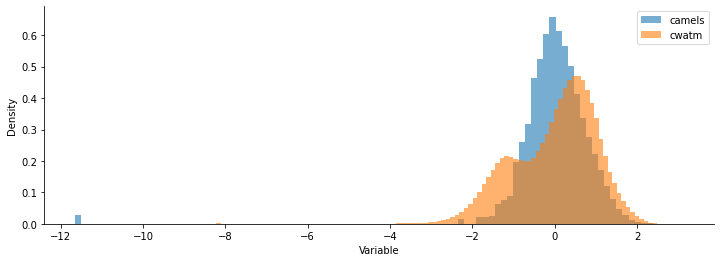

In [294]:
def plot_histograms(ds: xr.Dataset, var1: str = "camels", var2: str = "cwatm"):
    f, ax = plt.subplots(figsize=(12, 4))

    ax.hist(ds[var1].values.flatten(), density=True, bins=100, alpha=0.6, label=var1);
    ax.hist(ds[var2].values.flatten(), density=True, bins=100, alpha=0.6, label=var2);
    plt.legend()
    ax.set_title("")
    ax.set_xlabel("Variable")
    ax.set_ylabel("Density")
    sns.despine()
    
plot_histograms(norm_log_q)

# Hydrographs

In [355]:
def plot_timeseries_from_region(ds: xr.Dataset, region: str, var1: str = "camels", var2: str = "cwatm", time: str = "2000", twinx: bool = False, var1_color: str = "C0", var2_color: str = "C1", alpha=1):
    _d = ds.sel(station_id=ds["region"] == region)
    px = np.random.choice(_d.station_id.values)

    data = _d.sel(station_id=px, time=time)
    f, ax = plt.subplots(figsize=(12, 4))
    if twinx:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    ax.plot(data["time"], data[var1], label=var1, color=var1_color, alpha=alpha)
    ax2.plot(data["time"], data[var2], label=var2, color=var2_color, alpha=alpha)
    ax.set_title(f"{px} in {region}")
    ax.legend()
    


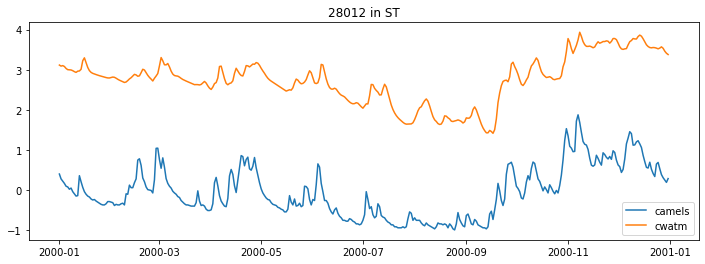

In [348]:
plot_timeseries_from_region(log_q, region="ST", var1="camels", var2="cwatm")

# What about precip?

In [367]:
epsilon = 1e-10
p = ds["precipitation"].rename("camels").to_dataset().merge(cw["Precipitation"].rename("cwatm"))

log_p = np.log(p + epsilon)
norm_log_p = (log_p - log_p.mean()) / log_p.std()

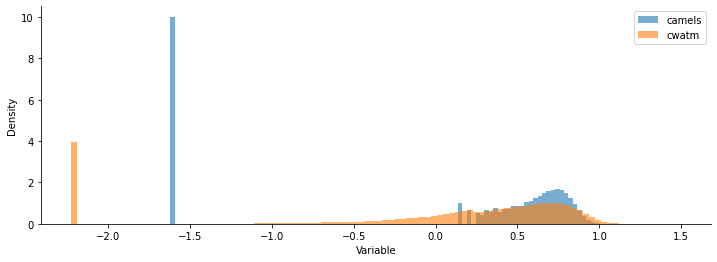

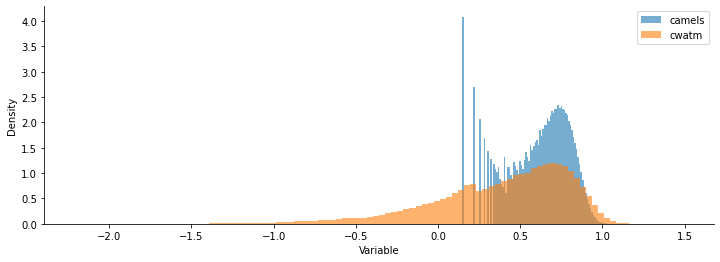

In [369]:
plot_histograms(norm_log_p)
# exclude zeros
exc_zero = norm_log_p.where(~(norm_log_p == norm_log_p.min()))
plot_histograms(exc_zero)

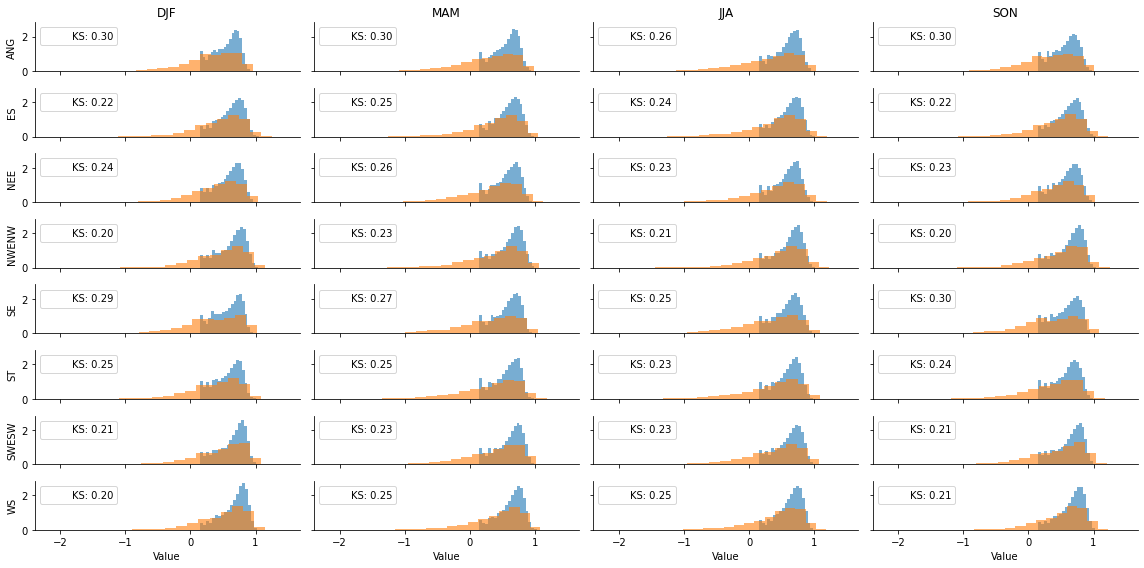

In [311]:
p_ks = plot_grid_of_histograms(exc_zero, var1, var2, regions, seasons)
p_ks = add_mean_rows_columns(p_ks)

Text(0.5, 1.0, 'Max: SE JJA\nMin: ES SON')

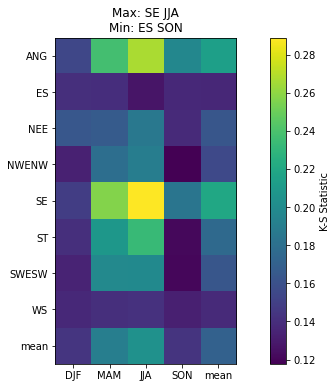

In [310]:
plot_ks(p_ks, seasons + ["mean"], regions + ["mean"]) # , imshow_kwargs={"vmin": 0.1, "vmax": 0.5})

# max region (by mean)
max_region = regions[np.argmax(p_ks[:, -1])]
max_season = seasons[np.argmax(p_ks[-1, :])]
min_region = regions[np.argmin(p_ks[:, -1])]
min_season = seasons[np.argmin(p_ks[-1, :])]
plt.gca().set_title(f"Max: {max_region} {max_season}\nMin: {min_region} {min_season}")

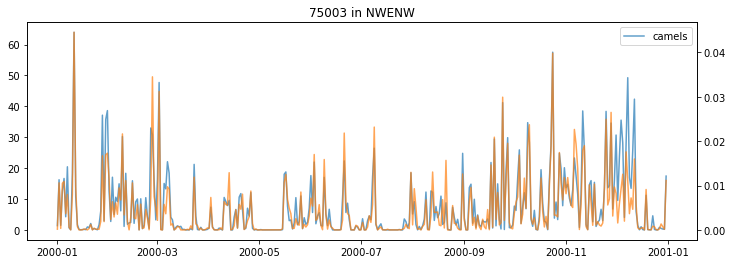

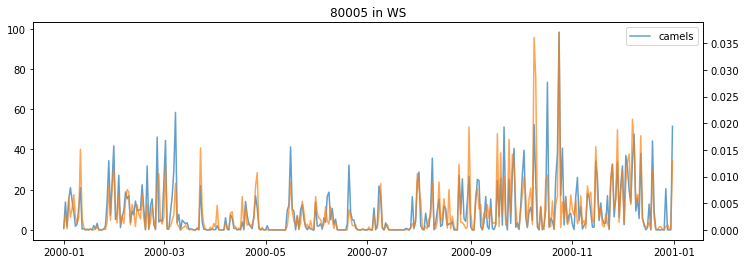

In [371]:
plot_timeseries_from_region(p, region="NWENW", twinx=True, var1_color="C0", var2_color="C1", alpha=0.7)
plot_timeseries_from_region(p, region="WS", twinx=True, var1_color="C0", var2_color="C1", alpha=0.7)
    

# _ds = p; var1: str = "camels"; var2: str = "cwatm"; time: str = "2000"
def plot_bar_from_region(_ds: xr.Dataset, region: str, var1: str = "camels", var2: str = "cwatm", time: str = "2000"):
    _d = _ds.sel(station_id=_ds["region"] == region)
    px = np.random.choice(_d.station_id.values)

    data = _d.sel(station_id=px, time=time)

    # plot barplot
    f, ax = plt.subplots(figsize=(12, 4))
    ax.bar(data["time"], data[var1], label=var1, color="C0", alpha=0.7)
    ax2 = ax.twinx()
    ax2.bar(data["time"], data[var2], label=var2, color="C1", alpha=0.7)

    ax.scatter(data["time"], data[var1], label=var1, color="C0", marker="x")
    ax2.scatter(data["time"], data[var2], label=var2, color="C1", marker="x")
    ax.set_title(f"{px} in {region}")

# plot_bar_from_region(p, region="SE")
# plot_bar_from_region(p, region="NWENW")

<AxesSubplot:>

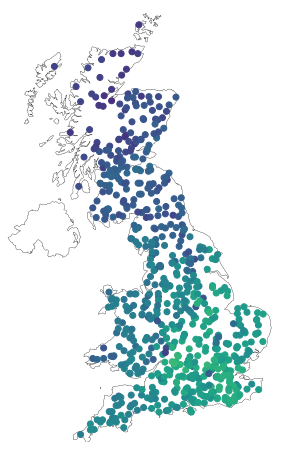

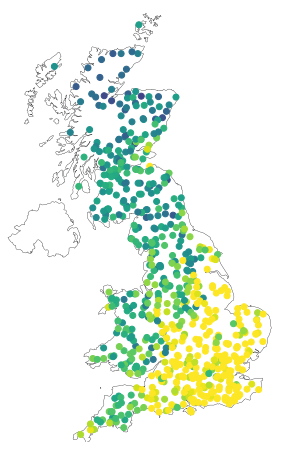

In [415]:
n_zeros = (p == 0).mean(dim="time")

ax = initialise_gb_spatial_plot()
gpd.GeoDataFrame(n_zeros.to_dataframe().join(points)).plot("cwatm", ax=ax, legend=False, vmin=0, vmax=0.35)

ax = initialise_gb_spatial_plot()
gpd.GeoDataFrame(n_zeros.to_dataframe().join(points)).plot("camels", ax=ax, legend=False, vmin=0, vmax=0.35)

<AxesSubplot:>

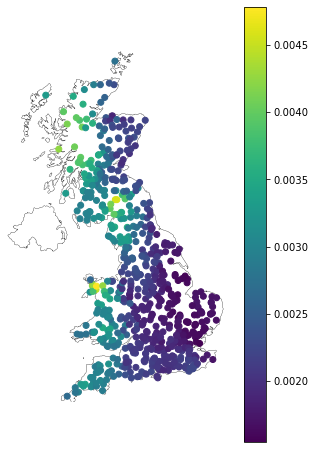

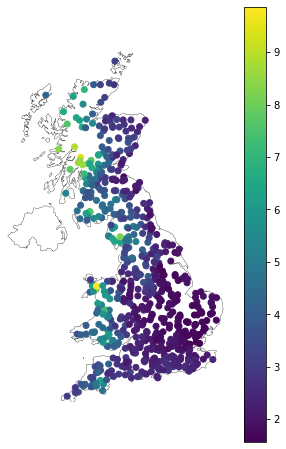

In [411]:
# mean_p = p.mean(dim="time")
# ax = initialise_gb_spatial_plot()
# gpd.GeoDataFrame(mean_p.to_dataframe().join(points)).plot("cwatm", ax=ax, legend=True)

# ax = initialise_gb_spatial_plot()
# gpd.GeoDataFrame(mean_p.to_dataframe().join(points)).plot("camels", ax=ax, legend=True)

Text(0.5, 1.0, 'Max: ANG JJA\nMin: NWENW DJF')

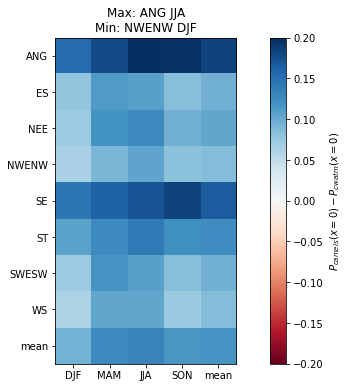

In [404]:
matrix_data = (p == 0).groupby("time.season").mean().groupby("region").mean()

m_cam = matrix_data["camels"].values
m_cwat = matrix_data["cwatm"].values

diff_m = m_cam - m_cwat
diff_m = add_mean_rows_columns(diff_m)
max_region = regions[np.argmax(diff_m[:, -1])]
max_season = seasons[np.argmax(diff_m[-1, :])]
min_region = regions[np.argmin(diff_m[:, -1])]
min_season = seasons[np.argmin(diff_m[-1, :])]

plot_region_season_matrix(diff_m, seasons + ["mean"], regions + ["mean"], cbar_kwargs={"label": "$P_{camels}(x=0) - P_{cwatm}(x=0)$"}, imshow_kwargs={"vmin": -0.2, "vmax": 0.2, "cmap": "RdBu"})
plt.gca().set_title("Blue = More zeros in Camels than CWatM \n Red = More Zeros in CWatM than Camels");

plt.gca().set_title(f"Max: {max_region} {max_season}\nMin: {min_region} {min_season}")

# What about CWatM Soil Moisture?

In [159]:
epsilon = 1e-10
sm = era5_ds["swvl1"].rename("era5").to_dataset().merge(cw["sum_w1"].rename("cwatm"))
norm_sm = (sm - sm.mean()) / sm.std()
sm

<xarray.Dataset>
Dimensions:      (station_id: 671, time: 9131)
Coordinates:
  * station_id   (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time         (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2014-12-31
    spatial_ref  int64 0
    region       (station_id) object 'WS' 'WS' 'WS' 'WS' ... 'NWENW' 'WS' nan
Data variables:
    era5         (station_id, time) float32 0.4618 0.4694 0.464 ... nan nan nan
    cwatm        (time, station_id) float32 0.00677 0.006781 ... 0.02269 0.0205

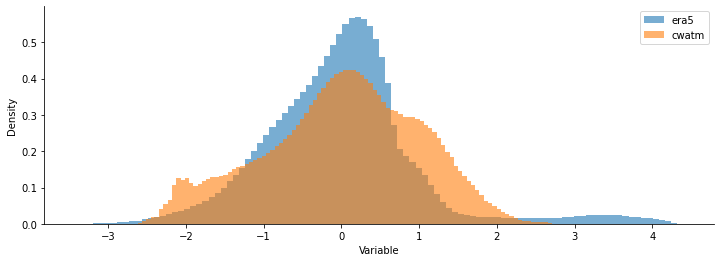

In [302]:
# f, ax = plt.subplots(figsize=(12, 4))

# ax.hist(norm_sm["era5"].values.flatten(), density=True, bins=100, alpha=0.6, label="ERA5 Land");
# ax.hist(norm_sm["cwatm"].values.flatten(), density=True, bins=100, alpha=0.6, label="CWatM");
# plt.legend()
# ax.set_title("")
# ax.set_xlabel("Normalised Soil Moisture")
# ax.set_ylabel("Density")
# sns.despine()

plot_histograms(norm_sm, var1="era5")

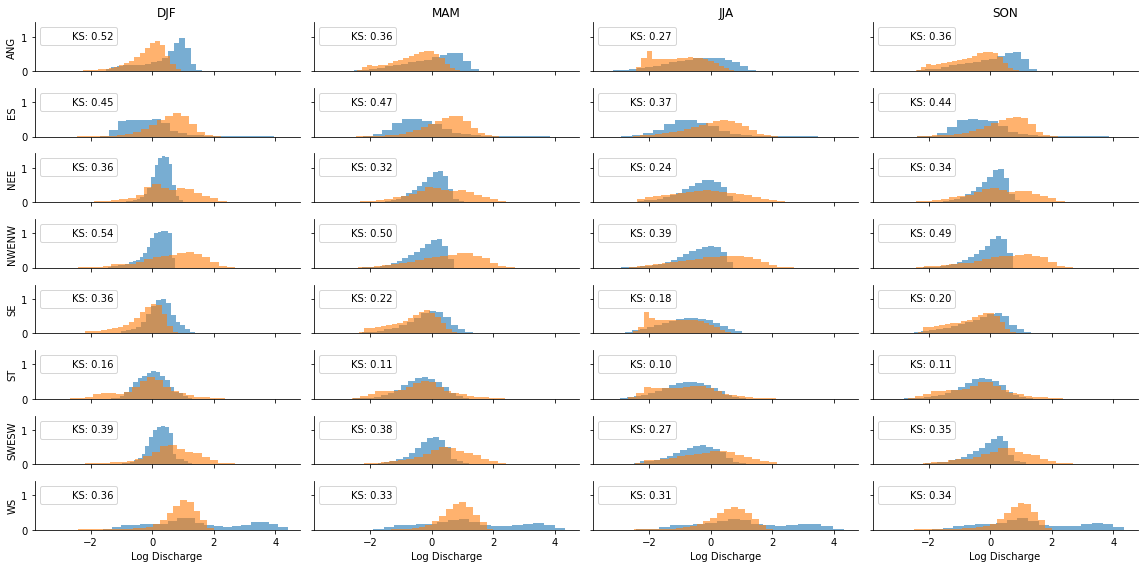

In [239]:
sm_ks = plot_grid_of_histograms(norm_sm, var1="era5", var2="cwatm", regions=regions, seasons=seasons)
sm_ks = add_mean_rows_columns(sm_ks)

Text(0.5, 1.0, 'Soil Moisture KS Test Statistic')

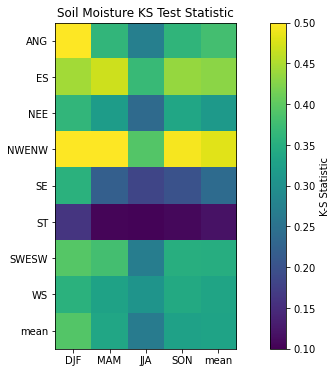

In [283]:
plot_ks(sm_ks, seasons + ["mean"], regions + ["mean"], imshow_kwargs={"vmin": 0.1, 'vmax': 0.5})
plt.gca().set_title("Soil Moisture KS Test Statistic")

### NWENW timeseries

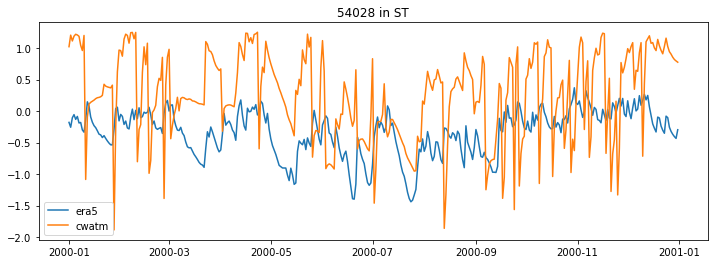

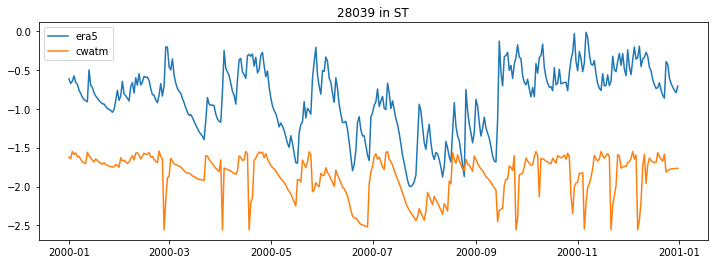

In [284]:
# log_q, var1, var2,
for _ in range(2):
    plot_timeseries_from_region(norm_sm, region="ST", time="2000", var1="era5", var2="cwatm")

# Low flows?

In [435]:
low_flow_mask = q["camels"] <= q["camels"].quantile(q=0.05)
lo_flo = norm_log_q.where(low_flow_mask)

Text(0.5, 1.0, 'Conditional Distribution of CWatM\n[P(CWatM | CAMELS < $q_{0.05}$)]')

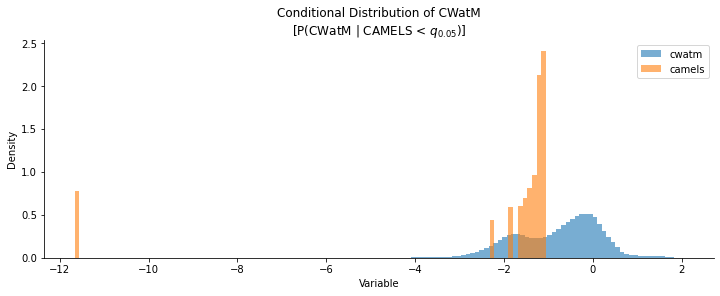

In [441]:
# lo_flo["cwatm"]
# lo_flo["camels"]

plot_histograms(lo_flo, var1="cwatm", var2="camels")
plt.gca().set_title("Conditional Distribution of CWatM\n[P(CWatM | CAMELS < $q_{0.05}$)]")